##Library

In [ ]:
import os
os.environ['CUDA_VISIblE_DEVICES'] = '0'
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision import transforms

##Hyperparameters

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [ ]:
config = AttrDict()

config.content_img = '/content/drive/MyDrive/neural-style-transfer/data/sung_min.jpg'
config.style_img = '/content/drive/MyDrive/neural-style-transfer/data/van_gogh_face.jpg'
config.save_path = '/content/drive/MyDrive/neural-style-transfer/save'
config.content_img_name = 'sung_min'
config.style_img_name = 'van_gogh_face'
config.n_epoch = 3000
config.log_interval = 100
config.save_interval = 100
config.style_loss_weight = 1
config.learning_rate = 0.01
config.img_size = 512

config.augmentation = transforms.Compose([
                        transforms.Resize(config.img_size),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
config.denormalize = lambda x: x * torch.tensor([[[0.229]], [[0.224]], [[0.255]]]) + torch.tensor([[[0.485]], [[0.456]], [[0.406]]])
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
if not os.path.isdir(config.save_path):
    os.makedirs(config.save_path)

In [ ]:
config.device

device(type='cuda')

##Data load

In [ ]:
def image_preprocess(image_path, transform=None, visualize_flag=False):
    image = Image.open(image_path)

    if visualize_flag:
        plt.title(f'Raw input image of {image_path}')
        plt.imshow(image)
        plt.show()

    if transform:
        image = transform(image)

        if visualize_flag:
            plt.title(f'Transformed input image of {image_path}')
            plt.imshow(config.denormalize(image).permute(1, 2, 0))
            plt.show()

    # 사진이 1장이기 때문에 임의로 batch demension을 확장
    return image.unsqueeze(0).to(config.device)

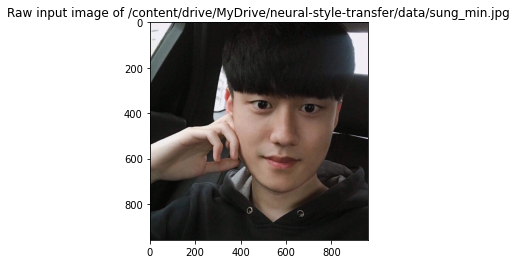

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


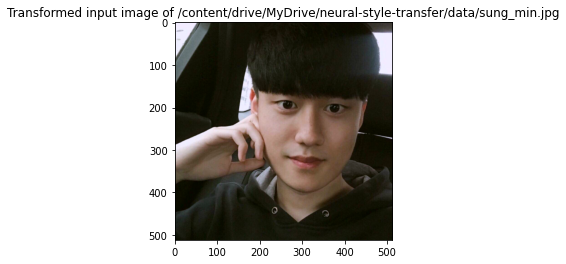

tensor([[[[ 2.0263,  2.0263,  2.0263,  ..., -1.0390, -1.0219, -1.0390],
          [ 2.0263,  2.0263,  2.0263,  ..., -1.0562, -1.0390, -1.0562],
          [ 2.0263,  2.0263,  2.0263,  ..., -1.0904, -1.0733, -1.0733],
          ...,
          [-1.9809, -1.9809, -1.9638,  ..., -1.8439, -1.8439, -1.8268],
          [-1.9809, -1.9809, -1.9638,  ..., -1.8097, -1.8268, -1.8268],
          [-1.9809, -1.9809, -1.9638,  ..., -1.8097, -1.8268, -1.8439]],

         [[ 2.1134,  2.1134,  2.1134,  ..., -1.0203, -1.0028, -1.0203],
          [ 2.1134,  2.1134,  2.1134,  ..., -1.0378, -1.0203, -1.0378],
          [ 2.1134,  2.1134,  2.1134,  ..., -1.0728, -1.0553, -1.0553],
          ...,
          [-1.8606, -1.8606, -1.8431,  ..., -1.7206, -1.7206, -1.7031],
          [-1.8606, -1.8606, -1.8431,  ..., -1.6856, -1.7031, -1.7031],
          [-1.8606, -1.8606, -1.8431,  ..., -1.6856, -1.7031, -1.7206]],

         [[ 2.4483,  2.4483,  2.4483,  ..., -0.7064, -0.6890, -0.6890],
          [ 2.4483,  2.4483,  

In [ ]:
image_preprocess(config.content_img, config.augmentation, True)

In [ ]:
content_img = image_preprocess(config.content_img, config.augmentation)
style_img = image_preprocess(config.style_img, config.augmentation)

# target_img는 학습되면서 update되는 이미지
target_img = content_img.clone().requires_grad_(True)

In [ ]:
models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
class feature_model(nn.Module):
    def __init__(self):
        super(feature_model, self).__init__()
        self.model = models.vgg19(pretrained=True).features
        self.selected_layer = ['0', '5', '10', '19', '28']

    def forward(self, x_list):
        feature_list = []
        for x in x_list:
            feature_list.append(self._forward(x))
        return feature_list

    def _forward(self, x):
        selected_features = []
        for n, layer in self.model._modules.items():
            x = layer(x)
            if n in self.selected_layer:
                selected_features.append(x)                                      
        return selected_features

In [ ]:
# update되는 것은 model이 아닌 image이기 때문에, optimizer에 image 변수를 넣어준다.
optimizer = torch.optim.Adam([target_img], lr=config.learning_rate)
criterion = nn.MSELoss()
model = feature_model().to(config.device)
# model은 학습하지 않으므로 model.eval() 호출
model.eval()

feature_model(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1

##Training

In [ ]:
for i in tqdm(range(config.n_epoch)):
    # 각각의 image에 대한 5개의 feature들
    c, s, t = model([content_img, style_img, target_img])

    style_loss = 0
    content_loss = 0

    for content_feature, style_feature, target_feature in zip(c, s, t):
        # target image가 초기값으로 사용된 content image와 같은 content를 유지하도록 하는 loss
        content_loss += criterion(target_feature, content_feature)

        # target image와 style image의 gram matrix를 계산
        # batch dimension 삭제 및 1d-vector로 flatten
        style_feature = style_feature.reshape(style_feature.shape[1], -1)
        target_feature = target_feature.reshape(target_feature.shape[1], -1)

        style_feature = torch.mm(style_feature, style_feature.t())
        target_feature = torch.mm(target_feature, target_feature.t())

        # target image와 style image의 gram matrix가 서로 같아지도록 하는 loss
        style_loss += criterion(target_feature, style_feature) / (style_feature.shape[0] * style_feature.shape[1])
    
    loss = content_loss + style_loss * config.style_loss_weight
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % config.log_interval == 0:
        print(f"Epoch [{i+1}/{config.n_epoch}] content_loss: {content_loss.item():.4f} style_loss: {style_loss.item():.4f}")

    if (i + 1) % config.save_interval == 0:
        save_path = os.path.join(config.save_path, 
                                 f"content_[{config.content_img_name}]_style_[{config.style_img_name}]_weight_[{config.style_loss_weight}]_epoch[{i+1}].png")

        # batch dimension 삭제
        save_img = target_img.squeeze(0).data.cpu() 
        save_img = config.denormalize(save_img).clamp(0., 1.)
        torchvision.utils.save_image(save_img, save_path)      

Epoch [2500/3000] content_loss: 18.1683 style_loss: 522.7717
Epoch [2600/3000] content_loss: 18.1717 style_loss: 498.1315
Epoch [2700/3000] content_loss: 18.1695 style_loss: 476.7757
Epoch [2800/3000] content_loss: 18.1638 style_loss: 458.0490
Epoch [2900/3000] content_loss: 18.1558 style_loss: 441.5682
Epoch [3000/3000] content_loss: 18.1490 style_loss: 427.0332
